In [1]:
import sys
sys.path.append('/home/ysilvy/Density_bining/Yona_analysis/programs/')
import os, glob
from netCDF4 import Dataset as open_ncfile
import matplotlib.pyplot as plt
from maps_matplot_lib import defVarmme, zon_2Dz, custom_div_cmap, modelagree
import numpy as np
import xarray as xr
from lib_remapping import remaptoz
from functions import remaptoz_xr
import pickle
import warnings
warnings.filterwarnings('ignore')

## Read every historical run

In [2]:
# == Read models ==
from modelsDef import defModels

models = defModels()

indir_histrcp85 = '/home/ysilvy/Density_bining/Yona_analysis/data/hist_rcp85/'

var_models = [0]*11
model_names = ['']*11
bowl_models = [0]*11
imod=0

for i, model in enumerate(models):
#i=2; model=models[i]
    # Read hist+rcp85 files
    listruns = sorted(glob.glob(indir_histrcp85 + 'cmip5.' + model['name'] + '.' + '*zon2D.nc'))
    listruns1d = sorted(glob.glob(indir_histrcp85 + 'cmip5.' + model['name'] + '.' + '*zon1D.nc'))
    nruns = len(listruns)
    if nruns != 0:
        print('Working on', model['name'])
        # Index of common time interval
        tstart = model['props'][2]
        tend = model['props'][3] #2005
        # Loop over number of runs
        for k in range(nruns):
            namefile = os.path.basename(listruns[k])
            run_nb = namefile.split('.')[3]
            print('    . run number', k, run_nb)

            fhrcp = xr.open_dataset(listruns[k],decode_times=False)
            vark = fhrcp.isonso.isel(time=slice(tend-20,tend)).mean(dim='time') #1985-2005
            fhrcp1d = xr.open_dataset(listruns1d[k],decode_times=False)
            bowlk = fhrcp1d.ptopsigma.isel(time=slice(tend-20,tend)).mean(dim='time')

            # Add dimension to stack members
            vark['members'] = run_nb
            vark = vark.expand_dims('members') 
            bowlk['members'] = run_nb
            bowlk = bowlk.expand_dims('members') 
            if k==0:
                bowl_mod = bowlk
                var_mod = vark
            else:
                bowl_mod = xr.concat([bowl_mod,bowlk],dim='members')
                var_mod = xr.concat([var_mod,vark],dim='members')
            
        model_names[imod] = model['name']
        bowl_models[imod] = bowl_mod
        var_models[imod] = var_mod
        imod=imod+1


Working on CanESM2
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
Working on CCSM4
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
    . run number 5 r6i1p1
Working on CESM1-CAM5
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
Working on CSIRO-Mk3-6-0
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
    . run number 5 r6i1p1
    . run number 6 r7i1p1
    . run number 7 r8i1p1
    . run number 8 r9i1p1
Working on FGOALS-g2
    . run number 0 r1i1p1
Working on GISS-E2-R
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r2i1p3
Working on HadGEM2-ES
    . run number 0 r1i1p1
    . run number 1 r3i1p1
Working on IPSL-CM5A-LR
    . run number 0 r2i1p1
    . run number 1 r3i1p1
    . run number 2 r4i1

## Compute ensemble means 

In [3]:
# Dimensions
basin = var_models[0].basin; basinN = len(basin)
lat = var_models[0].latitude; latN = len(lat)
lev = var_models[0].lev; levN = len(lev)
# Initialize xarrays
bowl_means = xr.DataArray(np.zeros((len(var_models),basinN,latN)),dims=['models','basin','latitude'],
                             coords=[model_names,basin,lat])
var_means = xr.DataArray(np.zeros((len(var_models),basinN,levN,latN)),dims=['models','basin','lev','latitude'],
                             coords=[model_names,basin,lev,lat])
# Loop on models to compute ensemble means
for i in range(len(var_models)):
    bowl_means[i,:,:] = bowl_models[i].mean(dim='members')
    var_means[i,:,:,:] = var_models[i].mean(dim='members')

## Compute multi-model means 

In [4]:
bowl_mmm = bowl_means.mean(dim='models')
var_mmm = var_means.mean(dim='models') 

## MMM hist-histNat [1985-2005]

In [5]:
indirhn = '/data/ysilvy/Density_binning/mme_histNat/'
filehn_2d = 'cmip5.multimodel_Nat_rcp85.historicalNat.ensm.an.ocn.Omon.density_zon2D.nc'
filehn_1d = 'cmip5.multimodel_Nat_rcp85.historicalNat.ensm.an.ocn.Omon.density_zon1D.nc'
fhn2d = xr.open_dataset(indirhn+filehn_2d,decode_times=False)
fhn1d = xr.open_dataset(indirhn+filehn_1d,decode_times=False)

varhn = fhn2d.isonso

var_change1 = var_mmm - varhn.isel(time=slice(125,145)).mean(dim='time')

# Mask above bowl
var_change1 = var_change1.where(bowl_mmm<var_change1.lev)

## MMM RCP8.5-histNat [2080-2100 - mean(histNat)]

In [6]:
indir_rcp85 = '/data/ericglod/Density_binning/Prod_density_april15/mme_rcp85/'
filercp85_2d = 'cmip5.multimodel_Nat.rcp85.ensm.an.ocn.Omon.density_zon2D.nc'
filercp85_1d = 'cmip5.multimodel_Nat.rcp85.ensm.an.ocn.Omon.density_zon1D.nc'

frcp2d = xr.open_dataset(indir_rcp85+filercp85_2d, decode_times=False)
frcp1d = xr.open_dataset(indir_rcp85+filercp85_1d, decode_times=False)

timercp = np.arange(2006,2101)
frcp2d['time'] = timercp
frcp1d['time'] = timercp

varrcp85 = frcp2d.isonso.sel(time=slice(2080,2100)).mean(dim='time')
var_change2 = varrcp85 - varhn.mean(dim='time')

bowlrcp85 = frcp1d.ptopsigma.sel(time=slice(2080,2100)).mean(dim='time')

# Mask above the bowl
var_change2 = var_change2.where(bowlrcp85<var_change2.lev) 

## Remap to z 

In [1]:
# == Read reference pseudo-depth used for remapping ==
indir_z = '/home/ysilvy/Density_bining/Yona_analysis/data/remaptoz/'
file_z = 'EN4.pseudo_depth.zonal.pkl'
pseudo_depth = pickle.load( open( indir_z+file_z, "rb" ))

# Repeat density into (basin,density,latitude) to remap isopycnal surfaces
lat2d,density2d = np.meshgrid(lat,lev)
density3d = np.repeat(density2d[np.newaxis,:,:],4,axis=0)

# == Target grid for remapping ==
# WOA13 grid
targetz = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
   85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
   400, 425, 450, 475, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
   1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
   1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2100, 2200, 2300,
   2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
   3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700,
   4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500]

# == Remap ==
var_change1_z, zbowl1 = remaptoz_xr(var_change1,pseudo_depth,targetz)
var_change2_z, zbowl2 = remaptoz_xr(var_change2,pseudo_depth,targetz)
density_z, zbowlbis = remaptoz(density3d,pseudo_depth,targetz)


NameError: name 'pickle' is not defined

In [8]:
varname = defVarmme('salinity'); v = 'S'
var = varname['var_zonal_w/bowl']
minmax = varname['minmax_zonal']
minmax_rcp = varname['minmax_zonal_rcp85']
legVar = varname['legVar']
unit = varname['unit']

## Plot hist-histNat 

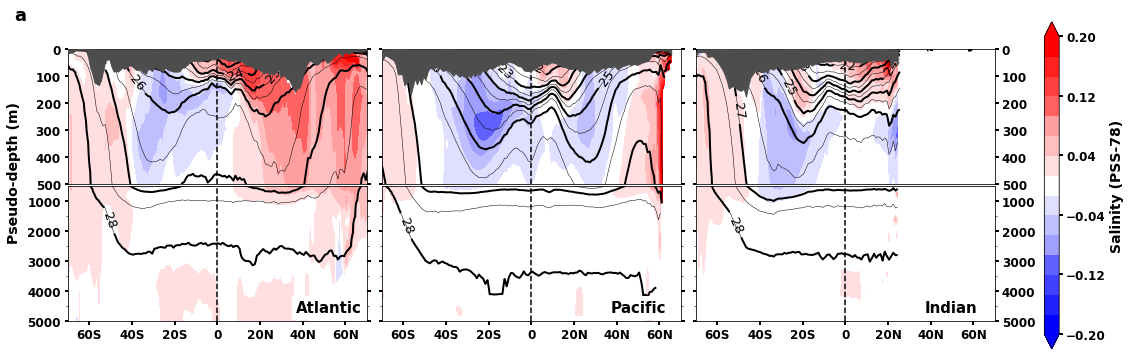

In [12]:
# -- Make variable bundles for each basin
varAtl = {'name': 'Atlantic', 'var_change': var_change1_z[1,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[1,:,:]}
varPac = {'name': 'Pacific', 'var_change': var_change1_z[2,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[2,:,:]}
varInd = {'name': 'Indian', 'var_change': var_change1_z[3,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[3,:,:]}

domzed = [0,500,5000]

# -- Create figure and axes instances
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

# -- color map
cmap = custom_div_cmap()

# -- levels
levels = np.linspace(minmax[0],minmax[1],minmax[2])

ext_cmap = 'both'
show_isopyc = True
contourDict = {'cmap':cmap, 'levels':levels, 'levels2':levels, 'ext_cmap':ext_cmap, 'isopyc':show_isopyc}

# -- Contourf of signal
cnplot = zon_2Dz(plt, axes[0,0], axes[1,0], 'left', lat, targetz, varAtl,
                 contourDict, domzed)
cnplot = zon_2Dz(plt, axes[0,1], axes[1,1], 'mid', lat, targetz, varPac,
                 contourDict, domzed)
cnplot = zon_2Dz(plt, axes[0,2], axes[1,2], 'right', lat, targetz, varInd,
                 contourDict, domzed)

lat2d, z2d = np.meshgrid(lat, targetz)
for i in range(3):
    # -- Draw bowl
    axes[0,i].fill_between(lat,y1=0,y2=zbowl1[i+1],color='0.3',zorder=10)
    
plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.05, right=0.86)
 
for ax in axes.ravel().tolist():
    ax.tick_params(axis='both', which='major', labelsize=12)
    
# -- Add colorbar
cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s (%s)' % (legVar, unit), fontweight='bold',fontsize=14)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold')
cb.ax.yaxis.set_tick_params(which='major',width=2,labelsize=12)

plt.figtext(.006,.96,'a',fontweight='bold',fontsize=18)
plt.figtext(.0005,.35,'Pseudo-depth (m)',rotation='vertical',fontweight='bold',fontsize=14)

plotTitle = 'MMM historical-historicalNat [1985-2005]'
# axes[0,1].set_title(plotTitle, y=1.25, fontweight='bold', fontsize=15, verticalalignment='top')

plt.savefig('fig2a.png', bbox_inches='tight',dpi=300) 

## Plot RCP8.5 - histNat 

In [20]:
regions = ['SO_subpolar_atl', 'SO_subpolar_pac', 'SO_subpolar_ind', 'SH_subtropics_atl', 'SH_subtropics_pac', 'SH_subtropics_ind', 'NH_subtropics_atl', 'NH_subtropics_pac', 'subpolar_northpac']
model_boxes = xr.DataArray(np.zeros((9,4)),dims=['regions','coord'],coords=[regions,['lat1','lat2','z1','z2']])
model_boxes[0] = [-68,-45,80,1500]
model_boxes[1] = [-68,-50,80,1500]
model_boxes[2] = [-68,-50,80,1500]
model_boxes[3] = [-38,-15,150,450]
model_boxes[4] = [-35,-10,150,450]
model_boxes[5] = [-40,-20,150,700]
model_boxes[6] = [25,45,80,700]
model_boxes[7] = [15,35,80,430]
model_boxes[8] = [40,60,50,900]

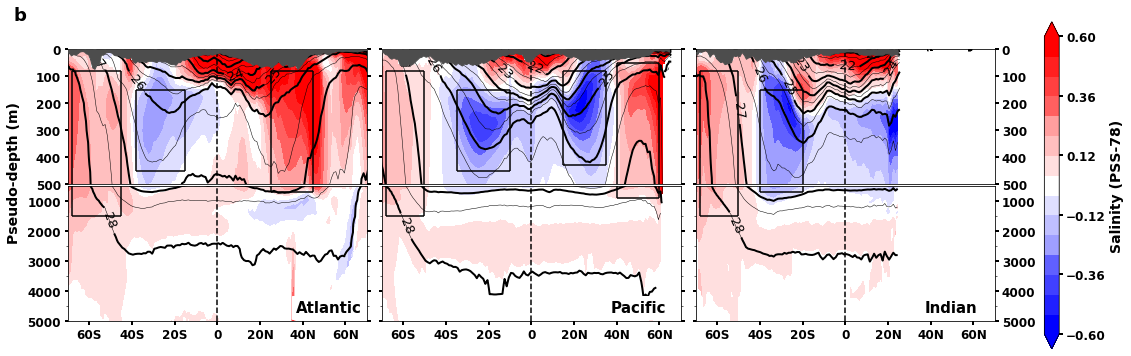

In [22]:
# -- Make variable bundles for each basin
varAtl2 = {'name': 'Atlantic', 'var_change': var_change2_z[1,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[1,:,:]}
varPac2 = {'name': 'Pacific', 'var_change': var_change2_z[2,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[2,:,:]}
varInd2 = {'name': 'Indian', 'var_change': var_change2_z[3,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[3,:,:]}

domzed = [0,500,5000]

# -- Create figure and axes instances
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

# -- color map
cmap = custom_div_cmap()

# -- levels
levels = np.linspace(minmax_rcp[0],minmax_rcp[1],minmax_rcp[2])

ext_cmap = 'both'
show_isopyc = True
contourDict = {'cmap':cmap, 'levels':levels, 'levels2':levels, 'ext_cmap':ext_cmap, 'isopyc':show_isopyc}

# -- Contourf of signal
cnplot = zon_2Dz(plt, axes[0,0], axes[1,0], 'left', lat, targetz, varAtl2,
                 contourDict, domzed)
cnplot = zon_2Dz(plt, axes[0,1], axes[1,1], 'mid', lat, targetz, varPac2,
                 contourDict, domzed)
cnplot = zon_2Dz(plt, axes[0,2], axes[1,2], 'right', lat, targetz, varInd2,
                 contourDict, domzed)

lat2d, z2d = np.meshgrid(lat, targetz)
for i in range(3):
    # -- Draw bowl
    axes[0,i].fill_between(lat,y1=0,y2=zbowl2[i+1],color='0.3',zorder=10)
    
plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.05, right=0.86)
 
for ax in axes.ravel().tolist():
    ax.tick_params(axis='both', which='major', labelsize=12)
    
# -- Plot boxes    
for i in range(3):
    for j in range(2):
        # Southern Ocean subpolar
        axes[j,i].hlines(y=(model_boxes[i][2],model_boxes[i][3]),xmin=model_boxes[i][0],xmax=model_boxes[i][1])
        axes[j,i].vlines(x=(model_boxes[i][0],model_boxes[i][1]),ymin=model_boxes[i][2],ymax=model_boxes[i][3])
        # SH subtropics
        axes[j,i].hlines(y=(model_boxes[i+3][2],model_boxes[i+3][3]),xmin=model_boxes[i+3][0],xmax=model_boxes[i+3][1])
        axes[j,i].vlines(x=(model_boxes[i+3][0],model_boxes[i+3][1]),ymin=model_boxes[i+3][2],ymax=model_boxes[i+3][3])
# NH subtropics atlantic
for i in range(2):
    axes[i,0].hlines(y=(model_boxes[6][2],model_boxes[6][3]),xmin=model_boxes[6][0],xmax=model_boxes[6][1])
    axes[i,0].vlines(x=(model_boxes[6][0],model_boxes[6][1]),ymin=model_boxes[6][2],ymax=model_boxes[6][3])
# NH subtropics pacific
for i in range(2):
    axes[i,1].hlines(y=(model_boxes[7][2],model_boxes[7][3]),xmin=model_boxes[7][0],xmax=model_boxes[7][1])
    axes[i,1].vlines(x=(model_boxes[7][0],model_boxes[7][1]),ymin=model_boxes[7][2],ymax=model_boxes[7][3])
# Subpolar north pacific
for i in range(2):
    axes[i,1].hlines(y=(model_boxes[8][2],model_boxes[8][3]),xmin=model_boxes[8][0],xmax=model_boxes[8][1])
    axes[i,1].vlines(x=(model_boxes[8][0],model_boxes[8][1]),ymin=model_boxes[8][2],ymax=model_boxes[8][3])


# -- Add colorbar
cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s (%s)' % (legVar, unit), fontweight='bold',fontsize=14)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold')
cb.ax.yaxis.set_tick_params(which='major',width=2,labelsize=12)

plt.figtext(.006,.96,'b',fontweight='bold',fontsize=18)
plt.figtext(.0005,.35,'Pseudo-depth (m)',rotation='vertical',fontweight='bold',fontsize=14)

plotTitle = 'MMM RCP8.5[2080-2100]-historicalNat'
# axes[0,1].set_title(plotTitle, y=1.25, fontweight='bold', fontsize=15, verticalalignment='top')

plt.savefig('fig2b.png', bbox_inches='tight',dpi=300) 